In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import shap
import pickle
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('synthetic_ec2_metrics.csv')
df.describe()

,CPUUtilization,DiskReadOps,DiskWriteOps,DiskReadBytes,DiskWriteBytes,NetworkIn,NetworkOut,NetworkPacketsIn,NetworkPacketsOut,anomaly
count,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,39.930235,50.087320,50.056204,1.003086e+06,9.998579e+05,498759.987676,499963.702535,299.526882,299.490345,0.168500
std,10.014660,14.974391,15.057578,2.000414e+05,1.973247e+05,101647.673138,100315.025405,49.371787,50.258367,0.374328
min,0.000000,-3.236014,-6.710717,2.593149e+05,2.794433e+05,124022.754522,165944.871749,100.484990,140.415884,0.000000
25%,33.124919,39.982292,39.920659,8.677371e+05,8.680782e+05,429262.371729,432618.848117,266.605837,266.287690,0.000000
50%,39.977293,49.995791,50.076585,1.001604e+06,9.993325e+05,498976.446940,501058.263092,299.796457,299.221455,0.000000
75%,46.870046,60.356653,60.333602,1.139159e+06,1.132020e+06,565687.909594,567695.248913,332.877261,333.556280,0.000000
max,78.957178,105.425785,115.141579,1.794027e+06,1.807266e+06,872528.969979,875323.901917,483.814183,472.075337,1.000000


In [3]:
print("\nBasic Info:")
print(df.info())
print("\nSummary Stats:")
print(df.describe())
print("\nCheck Nulls:\n", df.isnull().sum())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CPUUtilization     10000 non-null  float64
 1   DiskReadOps        10000 non-null  float64
 2   DiskWriteOps       10000 non-null  float64
 3   DiskReadBytes      10000 non-null  float64
 4   DiskWriteBytes     10000 non-null  float64
 5   NetworkIn          10000 non-null  float64
 6   NetworkOut         10000 non-null  float64
 7   NetworkPacketsIn   10000 non-null  float64
 8   NetworkPacketsOut  10000 non-null  float64
 9   anomaly            10000 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 781.4 KB
None

Summary Stats:
       CPUUtilization   DiskReadOps  DiskWriteOps  DiskReadBytes  \
count    10000.000000  10000.000000  10000.000000   1.000000e+04   
mean        39.930235     50.087320     50.056204   1.003086e+06   
std         10.014660     

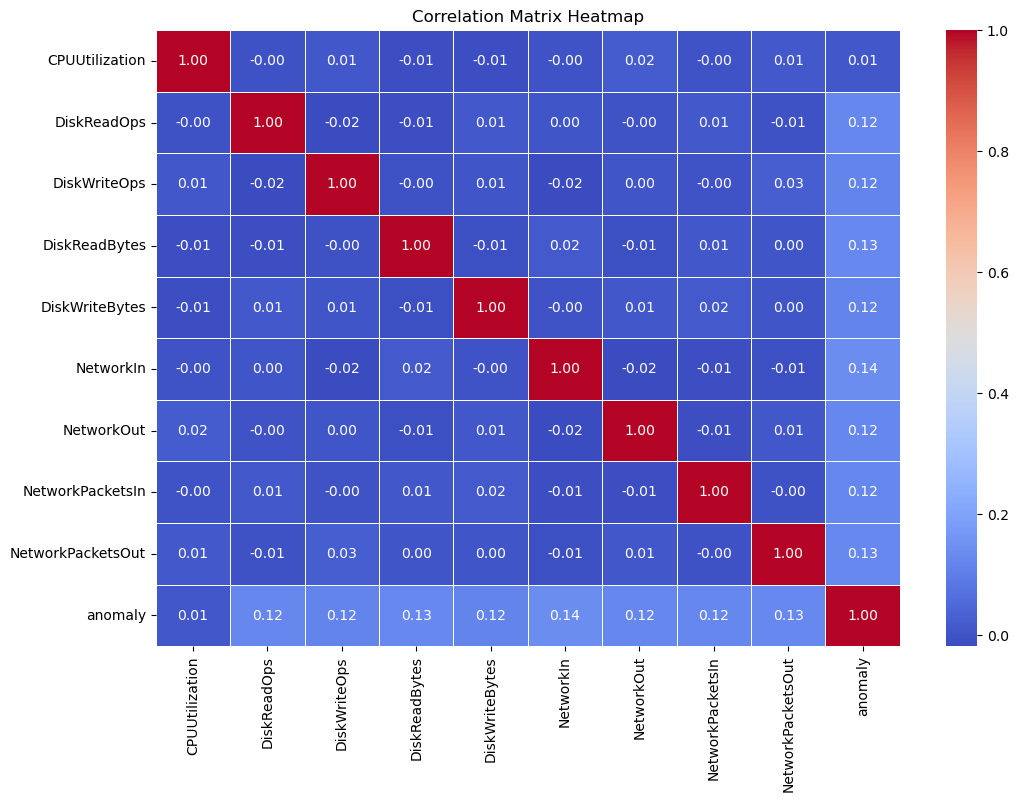

In [4]:
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [5]:
correlation_with_target = correlation_matrix['anomaly'].drop('anomaly').sort_values(ascending=False)
print(f'Top correlated features with Target \n{correlation_with_target}')

Top correlated features with Target 
NetworkIn            0.140383
NetworkPacketsOut    0.127201
DiskReadBytes        0.125925
DiskReadOps          0.123481
NetworkPacketsIn     0.123168
NetworkOut           0.122003
DiskWriteBytes       0.117269
DiskWriteOps         0.116934
CPUUtilization       0.007773
Name: anomaly, dtype: float64


In [6]:
X = df.drop('anomaly', axis=1)
y = df['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
# ----- Model Training -----
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [7]:
X_train

,CPUUtilization,DiskReadOps,DiskWriteOps,DiskReadBytes,DiskWriteBytes,NetworkIn,NetworkOut,NetworkPacketsIn,NetworkPacketsOut
9254,48.546050,45.381414,59.366127,7.708483e+05,1.052521e+06,547862.163496,473448.822232,270.005138,351.111365
1561,46.404718,42.030649,53.738291,9.904185e+05,9.907092e+05,485617.055425,580286.987041,214.058157,260.709785
1670,37.318666,47.339201,55.118040,1.389577e+06,1.045110e+06,371376.952739,555701.629595,378.121316,279.989799
6087,40.870236,44.871949,37.431503,1.026502e+06,6.254242e+05,341979.488128,389439.827455,281.791431,363.853113
6669,37.057183,73.039949,61.681747,8.680476e+05,8.374553e+05,500346.520552,637556.997040,341.037599,277.507607
...,...,...,...,...,...,...,...,...,...
5734,44.640126,36.192728,36.964249,1.070917e+06,8.602175e+05,719510.524497,393758.559197,274.587630,311.490869
5191,38.332616,64.552596,45.856394,9.996434e+05,9.646761e+05,596793.850229,437744.823177,306.321229,346.165292
5390,50.747955,66.216347,42.590176,9.905013e+05,7.333400e+05,518239.580241,446993.876784,226.705186,314.975888
860,39.715026,47.717901,61.449512,1.144740e+06,1.033931e+06,618950.880334,326215.368074,348.693362,363.573681


In [8]:
model_scores = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    model_scores[name] = acc
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds))

print(model_scores)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1659
           1       0.61      0.15      0.24       341

    accuracy                           0.84      2000
   macro avg       0.73      0.57      0.58      2000
weighted avg       0.81      0.84      0.80      2000


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1659
           1       0.99      1.00      1.00       341

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1659
           1       0.98      0.98      0.98       341

    accuracy                           0.99      2000
   macro avg  

In [9]:
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy: {model_scores[best_model_name]:.4f}")



Best Model: Random Forest with accuracy: 0.9985


In [11]:
# feature_names = X_train_scaled.columns.tolist()
# feature_importance = np.abs(shap_values).mean(0)

# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# importance_df = importance_df.sort_values('Importance', ascending=False)

# # top features with their importance values
# print(importance_df.head(10))


In [12]:
filename = f"anomoly_detection_{best_model_name.replace(' ', '_')}.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nModel saved as {filename}")


Model saved as anomoly_detection_Random_Forest.pkl
